In [ ]:
!pip install timm
!pip install fastai
!pip install fastcore

In [1]:
from fastai.data.all import *
from fastai.vision.all import *
import timm 
import torch
import os
from PIL import Image
from wwf.vision.object_detection import *
from wwf.vision.timm import *
import pandas as pd


In [10]:
class WORK_ENV:
    SOURCE_PATH = "sources/products_packaging/"
    TRAIN_CONF_PATH = "train"
    TEST_CONF_PATH = "val"

In [56]:
# Read the train.json content 
def get_source_annotations(root, path):
    full_path = root + path
    image_path = full_path + "/images"
    label_path = full_path + "/labels"
    
    classes_id = None
    with open(full_path + "/notes.json", 'r') as f:
        data = json.load(f)
        classes_id = {x['id']:x['name'] for x in data['categories']}
    
    files = os.listdir(image_path)
    images = []
    labels = []
    for img_name in files:
        file_id, _ = os.path.splitext(img_name)
        img_label_path = label_path + '/' + file_id + '.txt'
        bbox = []
        classes = []
        with open(img_label_path , 'r') as file:
            # Read each line of the file
            lines = file.readlines()
            image_width, image_height = Image.open(image_path+ '/' + img_name).size
            for line in lines:
                content = line.split(' ')
                
                # Define a bounding box in relative coordinates (x, y, width, height)
                relative_bbox = content[1:]
                
                # Convert to absolute coordinates
                # absolute_bbox = [float(coord) * image_width if i % 2 == 0 else float(coord) * image_height for i, coord in enumerate(relative_bbox)]
                
                absolute_bbox = [
                    float(relative_bbox[1]) * image_height,
                    float(relative_bbox[0]) * image_width,
                    float(relative_bbox[3]) * image_height,
                    float(relative_bbox[2]) * image_width,
                ]

                classes.append(classes_id[int(content[0])])
                bbox.append([absolute_bbox[0], absolute_bbox[1], absolute_bbox[2], absolute_bbox[3]])
        # break
        images.append(img_name)
        labels.append((bbox, classes))
    return images, labels, classes_id

In [33]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [57]:
images, lb_bbx, classes = get_source_annotations(WORK_ENV.SOURCE_PATH, WORK_ENV.TRAIN_CONF_PATH)
# img2bbox = dict(zip(images, lb_bbx))

In [58]:
test_images, test_lb_bbx, _ = get_source_annotations(WORK_ENV.SOURCE_PATH, WORK_ENV.TEST_CONF_PATH)
images.extend(test_images)
lb_bbx.extend(test_lb_bbx)
img2bbox = dict(zip(images, lb_bbx))

In [13]:
annotations, labels = zip(*lb_bbx)
f_label = [" ".join(sublist) for sublist in labels]
df = pd.DataFrame({'image': images, 'f_label': f_label, 'bbox': annotations, 'labels': labels})
df.to_csv(WORK_ENV.SOURCE_PATH + WORK_ENV.TRAIN_CONF_PATH + "/train.csv", index=False)

In [14]:
for cls in classes.values():
    df[cls] = df['f_label'].apply(lambda x: cls in x)


<Axes: >

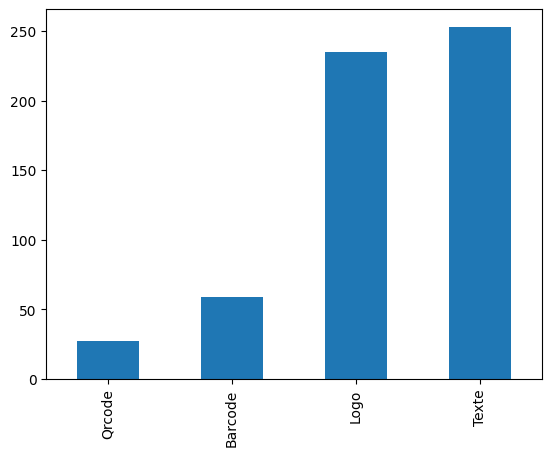

In [16]:
# Plot the frequency of each class
df[classes.values()].sum().sort_values().plot(kind='bar')

In [70]:
item_tfms = [Resize(128, method='pad')]
# batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]
prod = DataBlock(
     blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
     get_items=get_image_files,
     splitter=RandomSplitter(),
     get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
     item_tfms=item_tfms,
     # batch_tfms=batch_tfms,
     batch_tfms=[],
     n_inp=1
)
dls = prod.dataloaders(WORK_ENV.SOURCE_PATH + WORK_ENV.TRAIN_CONF_PATH + "/images", bs=16)
# dls = prod.dataloaders(WORK_ENV.SOURCE_PATH + WORK_ENV.TRAIN_CONF_PATH + "/images", bs=16, shuffle=True)


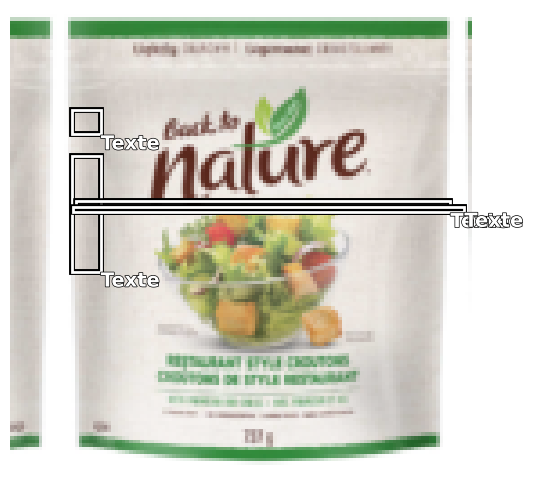

In [73]:
# dls.train.show_batch(unique=True, max_n=1, figsize=(13,13), show=True)
dls.train.show_batch(unique=True, max_n=1, figsize=(6,6), show=True)

In [118]:
# targets + background, targets, num_targets
dls.vocab, classes, get_c(dls)

(['#na#', 'Barcode', 'Logo', 'Qrcode', 'Texte'],
 {0: 'Barcode', 1: 'Logo', 2: 'Qrcode', 3: 'Texte'})

In [96]:
# Find the available models based on resnet34
# timm.list_models('resnet34', pretrained=True)[:10] 

['resnet34.a1_in1k',
 'resnet34.a2_in1k',
 'resnet34.a3_in1k',
 'resnet34.bt_in1k',
 'resnet34.gluon_in1k',
 'resnet34.tv_in1k']

In [179]:
body = create_timm_body('resnet34', pretrained=True)
arch = RetinaNet(body, get_c(dls), final_bias=-4)

In [192]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split, metrics=[error_rate, F1Score, Recall])

In [187]:
# Show the model architecture
# learn.summary() 

# Freeze the encoder for training
learn.freeze()

AttributeError: Exception occured in `GatherPredsCallback` when calling event `after_validate`:
	'int' object has no attribute 'index_select'

In [182]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4)) # Train the model a bit for a range of lr

KeyboardInterrupt: 

In [194]:
b = learn.dls.one_batch()

learn.one_batch(0, b) # Train the model a bit for a range of lr


AttributeError: Exception occured in `Recorder` when calling event `after_batch`:
	'AvgLoss' object has no attribute 'total'